In [1]:
import os
from datetime import datetime
from typing import List

import sys

sys.path.append(os.path.join('../src'))

import numpy as np
import pandas as pd
from decode_mcd import DesignTargets, ContinuousTarget, CounterfactualsGenerator

from mcd_clip.datasets.combined_datasets import CombinedDataset
from mcd_clip.datasets.validations_lists import COMBINED_VALIDATION_FUNCTIONS
from mcd_clip.optimization.combined_optimizer import CombinedOptimizer, distance_column_name, TextEmbeddingTarget, \
    ImageEmbeddingTarget
from mcd_clip.optimization.embedding_similarity_optimizer import to_full_clips_dataframe
from mcd_clip.resource_utils import run_result_path, resource_path

import nest_asyncio
nest_asyncio.apply()

from mcd_clip.singletons import IMAGE_CONVERTOR



def render_some(full_df: pd.DataFrame, run_dir: str, batch_number: int, distance_column_suffix: str):
    batch_dir = os.path.join(run_dir, f"batch_{batch_number}_distance_{distance_column_suffix}")
    os.makedirs(batch_dir, exist_ok=True)
    clips = to_full_clips_dataframe(CombinedDataset(full_df).get_as_clips())
    images_paths = []
    for idx in clips.index:
        rendering_result = IMAGE_CONVERTOR.to_image(clips.loc[idx])
        image_path = os.path.join(batch_dir, f"bike_{idx}.svg")
        images_paths.append(image_path)
        with open(image_path, "wb") as file:
            file.write(rendering_result.image)

def _selective_sample(
        optimizer: CombinedOptimizer,
        generator: CounterfactualsGenerator,
        distance_column_index: int):
    desired_weight = 1
    objective_weights = [desired_weight * (1 - distance_column_index), desired_weight * distance_column_index]
    as_many = generator.sample_with_weights(num_samples=100, cfc_weight=0,
                                            gower_weight=0, avg_gower_weight=0,
                                            diversity_weight=0,
                                            bonus_objectives_weights=np.array(objective_weights).reshape((1, 2)),
                                            include_dataset=False)
    column_ = distance_column_name(distance_column_index)
    as_many[column_] = optimizer.predict(CombinedDataset(as_many))[column_]
    closes_cfs = as_many.sort_values(by=column_, ascending=True)[:4]
    print(f"Found closest cfs {closes_cfs[distance_column_name(distance_column_index)]}")
    return closes_cfs


def _balance_sample(generator: CounterfactualsGenerator,
                    objective_weights: List[int],
                    diversity_weight: float,
                    n_samples: int):
    return generator.sample_with_weights(num_samples=n_samples, cfc_weight=1,
                                         gower_weight=1, avg_gower_weight=1,
                                         bonus_objectives_weights=np.array(objective_weights).reshape((1, 2)),
                                         diversity_weight=diversity_weight, include_dataset=False)


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dropping clips material columns ['MATERIAL OHCLASS: ALUMINIUM', 'MATERIAL OHCLASS: BAMBOO', 'MATERIAL OHCLASS: CARBON', 'MATERIAL OHCLASS: OTHER', 'MATERIAL OHCLASS: STEEL', 'MATERIAL OHCLASS: TITANIUM']


In [2]:
TEXT_TARGET = "A futuristic black cyberpunk-style road racing bicycle"
GENERATIONS = 200

optimizer = CombinedOptimizer(
    design_targets=DesignTargets(
        continuous_targets=[
            ContinuousTarget(distance_column_name(0), 0, 1),
            ContinuousTarget(distance_column_name(1), 0, 1),
        ]
    ),
    target_embeddings=[TextEmbeddingTarget(text_target=TEXT_TARGET),
                       ImageEmbeddingTarget(image_path=resource_path('mtb.png'))
                       ],
    extra_bonus_objectives=[]
)
optimizer.set_starting_design_by_index('1')
generator = optimizer.build_generator(validation_functions=COMBINED_VALIDATION_FUNCTIONS,
                                      features_to_vary=[f for f
                                                        in optimizer.starting_dataset.get_combined().columns
                                                        if ('bottle' not in f)
                                                        ]
                                      )
generator.use_empty_repair(False)
generator.generate(GENERATIONS, seed=45)

Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Dropping clips material columns ['MATERIAL OHCLASS: ALUMINIUM', 'MATERIAL OHCLASS: BAMBOO', 'MATERIAL OHCLASS: CARBON', 'MATERIAL OHCLASS: OTHER', 'MATERIAL OHCLASS: STEEL', 'MATERIAL OHCLASS: TITANIUM']
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Mater

/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


embedding_distance_1 | min 0.7400000095367432, max [0.7400000095367432],  average [0.7400000095367432]
embedding_distance_2 | min 0.15000000596046448, max [0.15000000596046448],  average [0.15000000596046448]
Starting design has in column embedding_distance_1 value 0.7360880374908447
Starting design has in column embedding_distance_2 value 0.1492699384689331
Number of validation functions is 6
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/interfacepoints.py:52: RuntimeWarning: invalid value encountered in sqrt
  DTx = np.sqrt(bike[:, 0] ** 2 - DTy ** 2)
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:210: RuntimeWarning: invalid value encountered in arccos
  tors_ang = np.arccos((TL ** 2 + sth_dist ** 2 - x_1) / (2 * TL * sth_dist))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:216: RuntimeWarning: invalid value encountered in arccos
  armpit_to_wrist = np.arccos((TL ** 2 + x_1 - sth_dist ** 2) / (2 * TL * (x_1 ** 0.5)))
/home/yazan/Repositories/Pe

Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/interfacepoints.py:52: RuntimeWarning: invalid value encountered in sqrt
  DTx = np.sqrt(bike[:, 0] ** 2 - DTy ** 2)
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:210: RuntimeWarning: invalid value encountered in arccos
  tors_ang = np.arccos((TL ** 2 + sth_dist ** 2 - x_1) / (2 * TL * sth_dist))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:216: RuntimeWarning: invalid value encountered in arccos
  armpit_to_wrist = np.arccos((TL ** 2 + x_1 - sth_dist ** 2) / (2 * TL * (x_1 ** 0.5)))


embedding_distance_1 | min 0.6899999976158142, max [1.0499999523162842],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.5199999809265137],  average [0.12999999523162842]
Mapping SSB_Include to choice with options (0, 1)
Mapping CSB_Include to choice with options (0, 1)
Mapped CS Length to Real with bounds (0.322943, 0.5569195)
Mapped BB Drop to Real with bounds (-0.0374885, 0.10553499999999999)
Mapped SS E to Real with bounds (0.015602500000000002, 0.223252)
Mapped ST Angle to Real with bounds (65.99998244937126, 78.99999375043305)
Mapped BB OD to Real with bounds (0.03484, 0.053875)
Mapped TT OD to Real with bounds (0.024204999999999997, 0.04801)
Mapped HT OD to Real with bounds (0.03099, 0.076855)
Mapped DT OD to Real with bounds (0.03, 0.06)
Mapped CS OD to Real with bounds (0.016825, 0.040269)
Mapped SS OD to Real with bounds (0.0105, 0.026099999999999998)
Mapped ST OD to Real with bounds (0.026561, 0.0556865)
Mapped CS F to Real with bounds (0

/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.7599999904632568],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [0.1899999976158142],  average [0.11999999731779099]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.009402654867256638]
Validation result: fraction invalid [0.00995575221238938]
Validation result: fraction invalid [0.041482300884955754]
Validation result: fraction invalid [0.04480088495575221]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.007190265486725664]
1808 dataset entries found matching problem parameters
Initial population initialized from dataset of 1808 samples!
Training GA from 0 to 200 generations!
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        0 |    206 |  0.000000E+00 |  0.1128318584 |             - |             -
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Mate

/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.02]
     2 |      100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.2132923199 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.09000000357627869, max [1.6799999475479126],  average [0.1899999976158142]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
     3 |      200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0104622602 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7200000286102295, max [0.7400000095367432],  average [0.7400000095367432]
embedding_distance_2 | min 0.12999999523162842, max [0.20000000298023224],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.01]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
     4 |      300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0329263537 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.7599999904632568],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [0.1899999976158142],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
     5 |      400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0039277472 |         ideal
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.659999966621399],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
     6 |      500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0264359059 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.11999999731779099, max [1.6799999475479126],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.01]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
     7 |      600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0482751485 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7200000286102295, max [0.7400000095367432],  average [0.7400000095367432]
embedding_distance_2 | min 0.11999999731779099, max [0.20000000298023224],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
     8 |      700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0087808873 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7200000286102295, max [0.7400000095367432],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [0.1899999976158142],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.01]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
     9 |      800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0096241974 |             f


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [1.1699999570846558],  average [0.7400000095367432]
embedding_distance_2 | min 0.12999999523162842, max [1.649999976158142],  average [0.17000000178813934]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.01]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    10 |      900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0076262395 |             f


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/mutation/pm.py:45: RuntimeWarning: invalid value encountered in power
  d = np.power(val, mut_pow) - 1.0


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.75],  average [0.7300000190734863]
embedding_distance_2 | min 0.10000000149011612, max [0.1899999976158142],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    11 |     1000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0566629203 |         ideal
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.649999976158142],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    12 |     1100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0153878974 |         ideal
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.75],  average [0.7200000286102295]
embedding_distance_2 | min 0.09000000357627869, max [0.1899999976158142],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    13 |     1200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0162861670 |         ideal
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.7900000214576721],  average [0.7300000190734863]
embedding_distance_2 | min 0.10000000149011612, max [0.2199999988079071],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    14 |     1300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0169602383 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6699999570846558],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.02]
    15 |     1400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0178744691 |         ideal
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [1.6799999475479126],  average [0.18000000715255737]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    16 |     1500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0439965536 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6699999570846558],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    17 |     1600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.1261893168 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.159999966621399],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6100000143051147],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    18 |     1700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0203898528 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.659999966621399],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    19 |     1800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0121692935 |         ideal
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.1899999976158142],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    20 |     1900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0563305565 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6200000047683716],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    21 |     2000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0025651219 |         ideal
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.11999999731779099, max [1.6699999570846558],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    22 |     2100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0075290275 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.09000000357627869, max [0.1899999976158142],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    23 |     2200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0093180621 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6200000047683716],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    24 |     2300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0284169288 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.75]
embedding_distance_2 | min 0.10000000149011612, max [1.690000057220459],  average [0.20999999344348907]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    25 |     2400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0145249926 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1299999952316284],  average [0.7300000190734863]
embedding_distance_2 | min 0.10000000149011612, max [1.4900000095367432],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    26 |     2500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0091795522 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.75],  average [0.7200000286102295]
embedding_distance_2 | min 0.09000000357627869, max [0.1899999976158142],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    27 |     2600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0487352711 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.7599999904632568],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [0.1899999976158142],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    28 |     2700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0131044954 |         ideal
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.649999976158142],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    29 |     2800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0189044356 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6399999856948853],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    30 |     2900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0134043572 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.20000000298023224],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    31 |     3000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0050822307 |         ideal
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.10999999940395355, max [1.6799999475479126],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    32 |     3100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0054627186 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.649999976158142],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    33 |     3200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0087700102 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/mutation/pm.py:45: RuntimeWarning: invalid value encountered in power
  d = np.power(val, mut_pow) - 1.0


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [1.6699999570846558],  average [0.18000000715255737]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    34 |     3300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0093652760 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [1.6699999570846558],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    35 |     3400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0055038944 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [0.8199999928474426],  average [0.7300000190734863]
embedding_distance_2 | min 0.10999999940395355, max [0.3700000047683716],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    36 |     3500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0065753570 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6699999570846558],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    37 |     3600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0276167951 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [1.6799999475479126],  average [0.1899999976158142]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    38 |     3700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0029370510 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.09000000357627869, max [1.6699999570846558],  average [0.18000000715255737]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.14]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    39 |     3800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0110053694 |             f


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.07999999821186066, max [1.690000057220459],  average [0.18000000715255737]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    40 |     3900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0123687638 |         nadir


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6799999475479126],  average [0.15000000596046448]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    41 |     4000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0142708156 |             f


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [1.1799999475479126],  average [0.75]
embedding_distance_2 | min 0.09000000357627869, max [1.6799999475479126],  average [0.2199999988079071]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    42 |     4100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0041415137 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.75],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [0.1899999976158142],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.01]
Validation result: fraction invalid [0.01]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    43 |     4200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0120635060 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [1.6699999570846558],  average [0.18000000715255737]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    44 |     4300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0125236661 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.75],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.1899999976158142],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    45 |     4400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0117865202 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.649999976158142],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    46 |     4500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0108804015 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/mutation/pm.py:45: RuntimeWarning: invalid value encountered in power
  d = np.power(val, mut_pow) - 1.0


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.10000000149011612, max [1.659999966621399],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.15]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    47 |     4600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0081074802 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.7699999809265137],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [0.20000000298023224],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    48 |     4700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0124359741 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.10000000149011612, max [1.649999976158142],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    49 |     4800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0132311265 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.17000000178813934],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    50 |     4900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0199371053 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.20000000298023224],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    51 |     5000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0158248599 |         ideal
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/mutation/pm.py:45: RuntimeWarning: invalid value encountered in power
  d = np.power(val, mut_pow) - 1.0


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.059999942779541],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [1.2400000095367432],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    52 |     5100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0114314239 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [1.6799999475479126],  average [0.17000000178813934]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.14]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    53 |     5200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0031904379 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.10000000149011612, max [1.6699999570846558],  average [0.17000000178813934]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    54 |     5300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0011453658 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6799999475479126],  average [0.1599999964237213]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    55 |     5400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0116609683 |             f


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6799999475479126],  average [0.15000000596046448]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    56 |     5500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0336998215 |         ideal


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [0.9900000095367432],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [0.9800000190734863],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    57 |     5600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0036414689 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.09000000357627869, max [0.1899999976158142],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    58 |     5700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0097726097 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7200000286102295, max [0.9300000071525574],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [0.7799999713897705],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    59 |     5800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0042685617 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [1.6799999475479126],  average [0.1899999976158142]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    60 |     5900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0063679447 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6699999570846558],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    61 |     6000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0138377167 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.7400000095367432],  average [0.7300000190734863]
embedding_distance_2 | min 0.10000000149011612, max [0.1899999976158142],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    62 |     6100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0161290323 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/mutation/pm.py:45: RuntimeWarning: invalid value encountered in power
  d = np.power(val, mut_pow) - 1.0


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6699999570846558],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    63 |     6200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0158730159 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.649999976158142],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    64 |     6300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0131135327 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.9700000286102295],  average [0.7400000095367432]
embedding_distance_2 | min 0.09000000357627869, max [0.9200000166893005],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    65 |     6400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0029882816 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.09000000357627869, max [1.6799999475479126],  average [0.18000000715255737]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.15]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.02]
    66 |     6500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0052764824 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6699999570846558],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    67 |     6600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0162620039 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.10000000149011612, max [1.659999966621399],  average [0.17000000178813934]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.15]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    68 |     6700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0126702614 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6699999570846558],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    69 |     6800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0097068774 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.75],  average [0.7200000286102295]
embedding_distance_2 | min 0.09000000357627869, max [0.18000000715255737],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    70 |     6900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0151196229 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


embedding_distance_1 | min 0.6899999976158142, max [1.1200000047683716],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.4700000286102295],  average [0.15000000596046448]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    71 |     7000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0082080684 |             f


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6799999475479126],  average [0.15000000596046448]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    72 |     7100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0240241223 |             f


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/mutation/pm.py:45: RuntimeWarning: invalid value encountered in power
  d = np.power(val, mut_pow) - 1.0


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.09000000357627869, max [0.18000000715255737],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    73 |     7200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0307692308 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.8299999833106995],  average [0.7200000286102295]
embedding_distance_2 | min 0.09000000357627869, max [0.3799999952316284],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    74 |     7300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0152664397 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.20000000298023224],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    75 |     7400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0156250000 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.10000000149011612, max [1.6799999475479126],  average [0.17000000178813934]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    76 |     7500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0048519084 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [0.75],  average [0.7300000190734863]
embedding_distance_2 | min 0.11999999731779099, max [0.20999999344348907],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    77 |     7600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0032411886 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6699999570846558],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    78 |     7700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0153846154 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


embedding_distance_1 | min 0.7099999785423279, max [1.1699999570846558],  average [0.75]
embedding_distance_2 | min 0.10999999940395355, max [1.659999966621399],  average [0.1899999976158142]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    79 |     7800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0015101136 |             f


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6799999475479126],  average [0.17000000178813934]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    80 |     7900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0106228887 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.10000000149011612, max [1.659999966621399],  average [0.17000000178813934]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    81 |     8000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0108277621 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6799999475479126],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    82 |     8100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0100974429 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [1.1699999570846558],  average [0.7400000095367432]
embedding_distance_2 | min 0.11999999731779099, max [1.659999966621399],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    83 |     8200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0053419395 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6799999475479126],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    84 |     8300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0156250000 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6799999475479126],  average [0.17000000178813934]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    85 |     8400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0122621008 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:4

embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [1.6699999570846558],  average [0.18000000715255737]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    86 |     8500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0071126372 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMI

/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    87 |     8600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0153846154 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1699999570846558],  average [0.7400000095367432]
embedding_distance_2 | min 0.10000000149011612, max [1.659999966621399],  average [0.17000000178813934]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    88 |     8700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0093424548 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.75],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [0.1899999976158142],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.01]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    89 |     8800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0093415822 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1699999570846558],  average [0.7400000095367432]
embedding_distance_2 | min 0.09000000357627869, max [1.649999976158142],  average [0.18000000715255737]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    90 |     8900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0111467144 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/mutation/pm.py:45: RuntimeWarning: invalid value encountered in power
  d = np.power(val, mut_pow) - 1.0


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7200000286102295, max [1.059999942779541],  average [0.7400000095367432]
embedding_distance_2 | min 0.11999999731779099, max [1.2400000095367432],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    91 |     9000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0055943062 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.75],  average [0.7200000286102295]
embedding_distance_2 | min 0.09000000357627869, max [0.18000000715255737],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    92 |     9100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0156250000 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.0299999713897705],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [1.1299999952316284],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    93 |     9200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0194842575 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.75],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.1899999976158142],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    94 |     9300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0147217869 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1699999570846558],  average [0.7400000095367432]
embedding_distance_2 | min 0.09000000357627869, max [1.649999976158142],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    95 |     9400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0040078217 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.09000000357627869, max [0.18000000715255737],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
    96 |     9500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0165680932 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/mutation/pm.py:45: RuntimeWarning: invalid value encountered in power
  d = np.power(val, mut_pow) - 1.0


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.09000000357627869, max [1.6699999570846558],  average [0.17000000178813934]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    97 |     9600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0109591769 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.8500000238418579],  average [0.7200000286102295]
embedding_distance_2 | min 0.09000000357627869, max [0.44999998807907104],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    98 |     9700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0153846154 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7200000286102295, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.10000000149011612, max [1.6699999570846558],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
    99 |     9800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0028922018 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.059999942779541],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.2200000286102295],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   100 |     9900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0139360521 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6699999570846558],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
   101 |    10000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0220078129 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6699999570846558],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
   102 |    10100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0181907184 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.149999976158142],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.5800000429153442],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   103 |    10200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0224264325 |         ideal
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6699999570846558],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   104 |    10300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0147111083 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [1.6699999570846558],  average [0.17000000178813934]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   105 |    10400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0292219526 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6800000071525574, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.649999976158142],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
   106 |    10500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0151515152 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.07999999821186066, max [1.6699999570846558],  average [0.18000000715255737]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   107 |    10600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0240388759 |         nadir


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.159999966621399],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.5800000429153442],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   108 |    10700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0185543006 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.11999999731779099, max [1.6699999570846558],  average [0.18000000715255737]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   109 |    10800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0030689200 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6799999475479126],  average [0.1599999964237213]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   110 |    10900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0092484174 |             f


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.7599999904632568],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [0.1899999976158142],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   111 |    11000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0037381412 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.7599999904632568],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [0.1899999976158142],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   112 |    11100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0192863804 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [1.1699999570846558],  average [0.7400000095367432]
embedding_distance_2 | min 0.10000000149011612, max [1.659999966621399],  average [0.17000000178813934]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.16]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   113 |    11200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0115045208 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.7599999904632568],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [0.20999999344348907],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
   114 |    11300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0182480247 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.649999976158142],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   115 |    11400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0143744404 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/mutation/pm.py:45: RuntimeWarning: invalid value encountered in power
  d = np.power(val, mut_pow) - 1.0


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.1899999976158142],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   116 |    11500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0158687204 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.75]
embedding_distance_2 | min 0.10000000149011612, max [1.6799999475479126],  average [0.20000000298023224]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.14]
Validation result: fraction invalid [0.16]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   117 |    11600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0039094329 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.7599999904632568],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [0.1899999976158142],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   118 |    11700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0299276867 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1699999570846558],  average [0.7400000095367432]
embedding_distance_2 | min 0.10000000149011612, max [1.6399999856948853],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.15]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   119 |    11800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0067471511 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [1.1699999570846558],  average [0.75]
embedding_distance_2 | min 0.11999999731779099, max [1.649999976158142],  average [0.18000000715255737]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   120 |    11900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0013392222 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1200000047683716],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.4299999475479126],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   121 |    12000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0153846154 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1399999856948853],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.5399999618530273],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   122 |    12100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0308509853 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.07999999821186066, max [1.6799999475479126],  average [0.18000000715255737]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   123 |    12200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0148247163 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [1.6699999570846558],  average [0.1899999976158142]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   124 |    12300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0091242999 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [1.1699999570846558],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [1.6699999570846558],  average [0.17000000178813934]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   125 |    12400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0057697868 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7200000286102295, max [1.1699999570846558],  average [0.75]
embedding_distance_2 | min 0.11999999731779099, max [1.659999966621399],  average [0.1899999976158142]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.01]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   126 |    12500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0026101329 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.10000000149011612, max [1.6699999570846558],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.16]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   127 |    12600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0104820548 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.8100000023841858],  average [0.7400000095367432]
embedding_distance_2 | min 0.11999999731779099, max [0.33000001311302185],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   128 |    12700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0016641977 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.0499999523162842],  average [0.7200000286102295]
embedding_distance_2 | min 0.09000000357627869, max [1.2300000190734863],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   129 |    12800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0159725186 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/mutation/pm.py:45: RuntimeWarning: invalid value encountered in power
  d = np.power(val, mut_pow) - 1.0


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.09000000357627869, max [0.18000000715255737],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   130 |    12900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0235584373 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7200000286102295, max [0.7400000095367432],  average [0.7400000095367432]
embedding_distance_2 | min 0.09000000357627869, max [0.18000000715255737],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   131 |    13000 |     99 |  0.000000E+00 |  0.000000E+00 |  0.0066132040 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.159999966621399],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.590000033378601],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   132 |    13100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0151515152 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [1.1799999475479126],  average [0.7599999904632568]
embedding_distance_2 | min 0.11999999731779099, max [1.6799999475479126],  average [0.23000000417232513]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   133 |    13200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0060128686 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.10000000149011612, max [1.6699999570846558],  average [0.17000000178813934]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.15]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   134 |    13300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0108816351 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.100000023841858],  average [0.7300000190734863]
embedding_distance_2 | min 0.07000000029802322, max [1.4299999475479126],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   135 |    13400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0093617896 |         ideal
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.75],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.20000000298023224],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   136 |    13500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0153846154 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.090000033378601],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.3600000143051147],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   137 |    13600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0130764694 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6800000071525574, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.18000000715255737],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   138 |    13700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0119719746 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.75]
embedding_distance_2 | min 0.09000000357627869, max [1.6799999475479126],  average [0.2199999988079071]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   139 |    13800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0088190162 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.649999976158142],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   140 |    13900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0072618597 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


embedding_distance_1 | min 0.6899999976158142, max [1.090000033378601],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.340000033378601],  average [0.15000000596046448]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   141 |    14000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0192072556 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6699999570846558],  average [0.15000000596046448]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
   142 |    14100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0141226459 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.659999966621399],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.14]
Validation result: fraction invalid [0.14]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   143 |    14200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0097808949 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6699999570846558],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.14]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   144 |    14300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0186118817 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [0.75],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [0.1899999976158142],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   145 |    14400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0028978294 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6799999475479126],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.14]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.14]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   146 |    14500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0117800606 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.159999966621399],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6299999952316284],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   147 |    14600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0156250000 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [1.1399999856948853],  average [0.7400000095367432]
embedding_distance_2 | min 0.11999999731779099, max [1.5399999618530273],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   148 |    14700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0035312617 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1100000143051147],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.4199999570846558],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
   149 |    14800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0447761194 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.059999942779541],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.2300000190734863],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   150 |    14900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0468750000 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.1899999976158142],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   151 |    15000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0177320320 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/mutation/pm.py:45: RuntimeWarning: invalid value encountered in power
  d = np.power(val, mut_pow) - 1.0


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1200000047683716],  average [0.7400000095367432]
embedding_distance_2 | min 0.09000000357627869, max [1.4700000286102295],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.14]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   152 |    15100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0102487978 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6399999856948853],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   153 |    15200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0167011921 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.1899999976158142],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   154 |    15300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0294487204 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


embedding_distance_1 | min 0.6899999976158142, max [0.7599999904632568],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [0.18000000715255737],  average [0.12999999523162842]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
   155 |    15400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0174815959 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.7699999809265137],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.1899999976158142],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   156 |    15500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0125539674 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.09000000357627869, max [1.6699999570846558],  average [0.17000000178813934]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   157 |    15600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0034782139 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


embedding_distance_1 | min 0.6899999976158142, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6399999856948853],  average [0.15000000596046448]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.14]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.14]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   158 |    15700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0084449325 |             f


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7200000286102295, max [1.1799999475479126],  average [0.75]
embedding_distance_2 | min 0.11999999731779099, max [1.6699999570846558],  average [0.18000000715255737]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   159 |    15800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0037318341 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/mutation/pm.py:45: RuntimeWarning: invalid value encountered in power
  d = np.power(val, mut_pow) - 1.0


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.690000057220459],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.15]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   160 |    15900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0048047321 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/mutation/pm.py:45: RuntimeWarning: invalid value encountered in power
  d = np.power(val, mut_pow) - 1.0


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.18000000715255737],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   161 |    16000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0143244618 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [1.6699999570846558],  average [0.18000000715255737]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   162 |    16100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0109750025 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.1899999976158142],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   163 |    16200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0386144130 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.09000000357627869, max [0.1899999976158142],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   164 |    16300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0055813821 |         ideal
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.75],  average [0.7200000286102295]
embedding_distance_2 | min 0.09000000357627869, max [0.1899999976158142],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   165 |    16400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0125253726 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [0.75],  average [0.7300000190734863]
embedding_distance_2 | min 0.10999999940395355, max [0.1899999976158142],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   166 |    16500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0104635374 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.649999976158142],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   167 |    16600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0156360038 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6699999570846558],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   168 |    16700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0133331094 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7200000286102295, max [0.75],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [0.1899999976158142],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   169 |    16800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0036342131 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7200000286102295, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [1.6699999570846558],  average [0.17000000178813934]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   170 |    16900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0046829538 |             f


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6299999952316284],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/interfacepoints.py:52: RuntimeWarning: invalid value encountered in sqrt
  DTx = np.sqrt(bike[:, 0] ** 2 - DTy ** 2)
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/interfacepoints.py:52: RuntimeWarning: invalid value encountered in sqrt
  DTx = np.sqrt(bike[:, 0] ** 2 - DTy ** 2)
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: 

Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   171 |    17000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0183054176 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6699999570846558],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   172 |    17100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0195360439 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.659999966621399],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.14]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   173 |    17200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0127613188 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.1899999976158142],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
   174 |    17300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0307692308 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6800000071525574, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.18000000715255737],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.14]
Validation result: fraction invalid [0.17]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   175 |    17400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0142181855 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6699999570846558],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   176 |    17500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0205864122 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.09000000357627869, max [1.6799999475479126],  average [0.1899999976158142]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.15]
Validation result: fraction invalid [0.14]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   177 |    17600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0087507773 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.75],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [0.1899999976158142],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   178 |    17700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0142980274 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6699999570846558],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.01]
   179 |    17800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0148561232 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.159999966621399],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.590000033378601],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.19]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   180 |    17900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0179443500 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [1.1699999570846558],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [1.659999966621399],  average [0.18000000715255737]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.12]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   181 |    18000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0070635461 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6699999570846558],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   182 |    18100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0151515152 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [1.1699999570846558],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [1.6299999952316284],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   183 |    18200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0051920831 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/mutation/pm.py:45: RuntimeWarning: invalid value encountered in power
  d = np.power(val, mut_pow) - 1.0


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.7699999809265137],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.18000000715255737],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   184 |    18300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0269832767 |         ideal
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.659999966621399],  average [0.17000000178813934]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   185 |    18400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0088279395 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


embedding_distance_1 | min 0.6899999976158142, max [1.159999966621399],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.600000023841858],  average [0.14000000059604645]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.02]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   186 |    18500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0554586801 |         nadir


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [0.75],  average [0.7400000095367432]
embedding_distance_2 | min 0.10999999940395355, max [0.1899999976158142],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   187 |    18600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0035127787 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.7099999785423279, max [1.149999976158142],  average [0.7400000095367432]
embedding_distance_2 | min 0.11999999731779099, max [1.559999942779541],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   188 |    18700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0049345304 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1699999570846558],  average [0.7400000095367432]
embedding_distance_2 | min 0.07999999821186066, max [1.649999976158142],  average [0.18000000715255737]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.15]
Validation result: fraction invalid [0.14]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   189 |    18800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0186645723 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.6699999570846558],  average [0.15000000596046448]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   190 |    18900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0154901531 |             f


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1699999570846558],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.659999966621399],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   191 |    19000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0100699114 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.149999976158142],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.5399999618530273],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.03]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   192 |    19100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0101053100 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.100000023841858],  average [0.7300000190734863]
embedding_distance_2 | min 0.07999999821186066, max [1.3799999952316284],  average [0.14000000059604645]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   193 |    19200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0106230525 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [0.7599999904632568],  average [0.7200000286102295]
embedding_distance_2 | min 0.07999999821186066, max [0.1899999976158142],  average [0.12999999523162842]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   194 |    19300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0150705334 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.75]
embedding_distance_2 | min 0.10999999940395355, max [1.6699999570846558],  average [0.1899999976158142]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   195 |    19400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0044865176 |             f
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6799999475479126],  average [0.1599999964237213]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.18]
Validation result: fraction invalid [0.17]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   196 |    19500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0091820117 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1799999475479126],  average [0.7300000190734863]
embedding_distance_2 | min 0.09000000357627869, max [1.6699999570846558],  average [0.15000000596046448]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   197 |    19600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0587149328 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.07999999821186066, max [1.6699999570846558],  average [0.1899999976158142]
Validation result: fraction invalid [0.07]
Validation result: fraction invalid [0.08]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.04]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   198 |    19700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0146083269 |             f


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.6899999976158142, max [1.1799999475479126],  average [0.7400000095367432]
embedding_distance_2 | min 0.07999999821186066, max [1.6799999475479126],  average [0.18000000715255737]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.11]
Validation result: fraction invalid [0.05]
Validation result: fraction invalid [0.06]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   199 |    19800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0126842475 |         nadir
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM


/home/yazan/Repositories/Personal/mcd-clip/venv/lib/python3.10/site-packages/pymoo/operators/crossover/sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
embedding_distance_1 | min 0.699999988079071, max [1.1699999570846558],  average [0.7400000095367432]
embedding_distance_2 | min 0.10000000149011612, max [1.659999966621399],  average [0.1899999976158142]


/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/demoanalysis.py:76: RuntimeWarning: invalid value encountered in arccos
  Tksp2 = np.arccos(
/home/yazan/Repositories/Personal/mcd-clip/notebooks/../src/mcd_clip/bike_rider_fit/fit_analysis/vectorizedangles.py:158: RuntimeWarning: invalid value encountered in arccos
  alpha_1 = np.arccos((x_1 ** 2 - UL_s - x_2 ** 2) / (-2 * UL * x_2))


Validation result: fraction invalid [0.1]
Validation result: fraction invalid [0.09]
Validation result: fraction invalid [0.16]
Validation result: fraction invalid [0.13]
Validation result: fraction invalid [0.0]
Validation result: fraction invalid [0.0]
   200 |    19900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0100983223 |             f


In [ ]:
desired_weight = -1
distance_column_index = 1
objective_weights = [desired_weight * (1 - distance_column_index), desired_weight * distance_column_index]
as_many = generator.sample_with_weights(num_samples=4, cfc_weight=0,
                                        gower_weight=0.05, avg_gower_weight=0.5,
                                        diversity_weight=0,
                                        bonus_objectives_weights=np.array(objective_weights).reshape((1, 2)),
                                        include_dataset=False)
column_ = distance_column_name(distance_column_index)
as_many[column_] = optimizer.predict(CombinedDataset(as_many))[column_]
closes_cfs = as_many.sort_values(by=column_, ascending=True)[:4]
print(f"Found closest cfs {closes_cfs[distance_column_name(distance_column_index)]}")


In [ ]:
render_some(closes_cfs, 'reg-run', 1, 'both')

Rendering image...
Scoring all counterfactual candidates!
Done! Returning CFs
Found framed material columns ['Material=Steel', 'Material=Aluminum', 'Material=Titanium']
Mapping Material=Steel to MATERIAL OHCLASS: STEEL
Mapping Material=Aluminum to MATERIAL OHCLASS: ALUMINUM
Mapping Material=Titanium to MATERIAL OHCLASS: TITANIUM
Deleting key MATERIAL OHCLASS: ALUMINIUM
Deleting key MATERIAL OHCLASS: BAMBOO
Deleting key MATERIAL OHCLASS: CARBON
Deleting key MATERIAL OHCLASS: OTHER
Deleting key MATERIAL OHCLASS: STEEL
Deleting key MATERIAL OHCLASS: TITANIUM
Deleting key Dropout spacing style OHCLASS: 0
Deleting key Dropout spacing style OHCLASS: 1
Deleting key Dropout spacing style OHCLASS: 2
Deleting key Dropout spacing style OHCLASS: 3
Deleting key Fork type OHCLASS: 0
Deleting key Fork type OHCLASS: 1
Deleting key Fork type OHCLASS: 2
Deleting key Stem kind OHCLASS: 0
Deleting key Stem kind OHCLASS: 1
Deleting key Stem kind OHCLASS: 2
Deleting key Handlebar style OHCLASS: 0
Deleting k

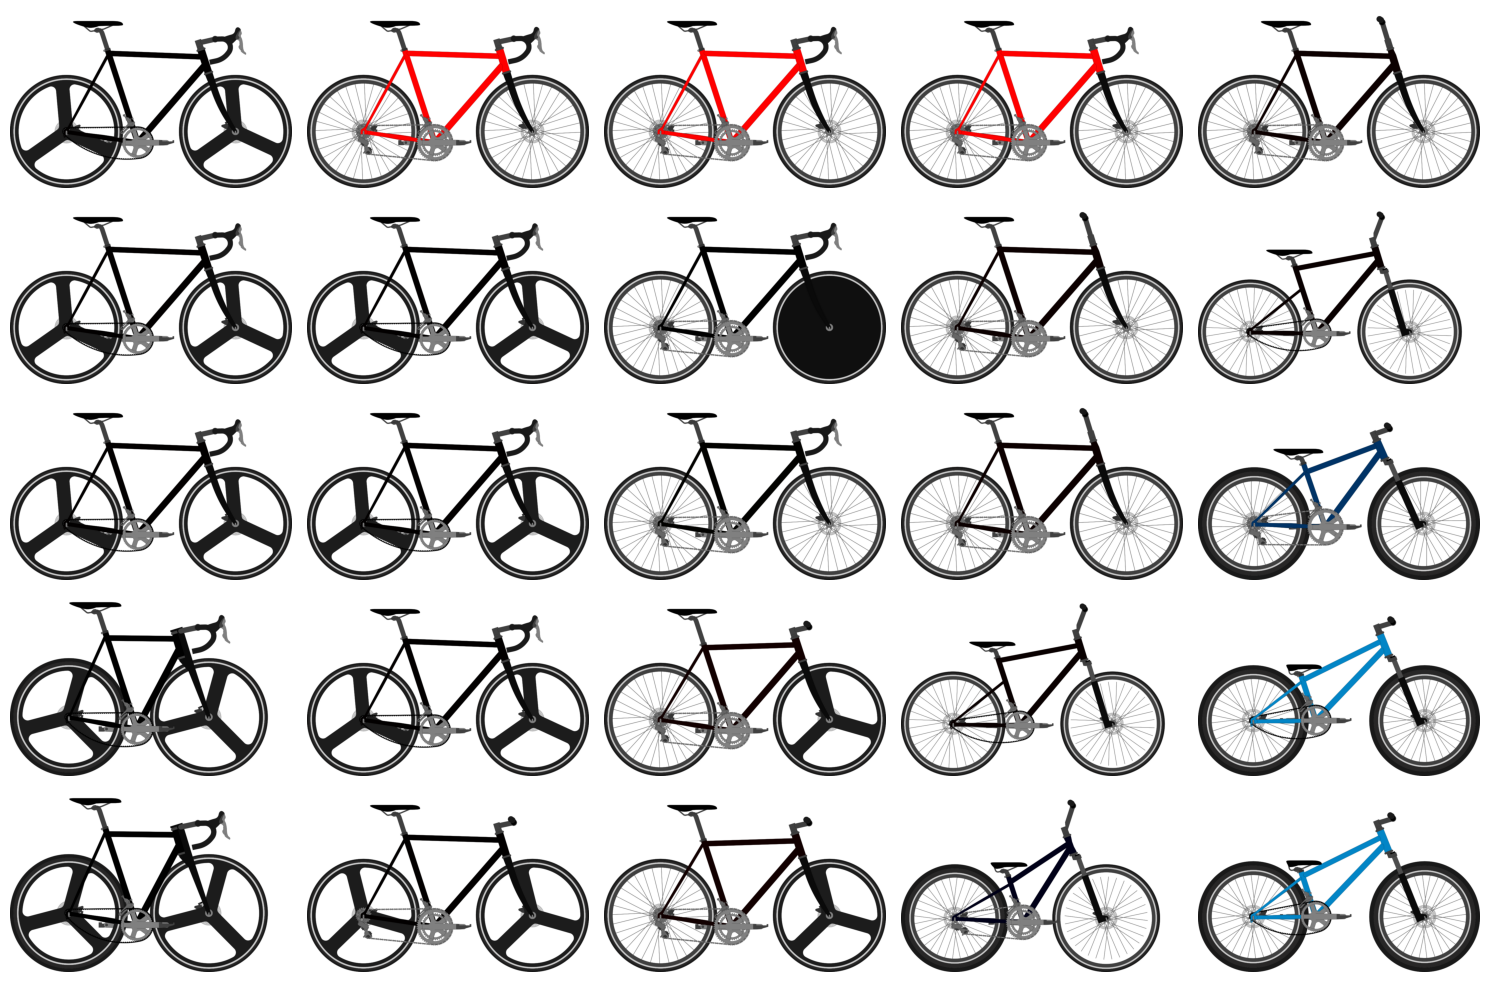

In [7]:
import cairosvg
from PIL import Image
from matplotlib import pyplot as plt
import io
from mcd_clip.bike_rendering.parametric_to_image_convertor import RENDERING_SERVICE
from mcd_clip.bike_rendering.bikeCad_renderer import RenderingService
from time import time

n = 5

fig, axs = plt.subplots(n, n, figsize=(15, 10))


for i in range(n):
    for j in range(n):
        print("Rendering image...")
        exp = 1.5  # shift to 1.3?
        num = 1.5
        bike = generator.sample_with_weights(num_samples=1, cfc_weight=num/(exp ** j),
                                            gower_weight=num/(exp ** j), avg_gower_weight=num/(exp ** j),
                                            diversity_weight=0,
                                             # [-(2 ** i), 1 * -(2 ** (n - 1 -i))]
                                            bonus_objectives_weights=np.array([1 * -(2 ** (n - 1 -i)), 
                                                                               -(2 ** i)]).reshape((1, 2)),
                                            include_dataset=True)
        clips = to_full_clips_dataframe(CombinedDataset(bike).get_as_clips())
        rendering_result = IMAGE_CONVERTOR.to_image(clips.iloc[0])
        ax = axs[j, i]
        image_open = Image.open(io.BytesIO(cairosvg.svg2png(rendering_result.image)))
        ax.imshow(np.asarray(image_open, dtype='int32'))
        ax.axis('off')
plt.tight_layout()
plt.savefig(f'run-{time()}.png')